In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("./dataset/leak_detection_water_1000_rows.csv")


In [14]:
# Explore the data
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum().sum())

print(df.columns)

Dataset shape: (1000, 7)

First few rows:
             Timestamp Sensor_ID  Pressure (bar)  Flow Rate (L/s)  \
0  2024-01-01 00:00:00      S007        3.694814        77.515218   
1  2024-01-01 00:05:00      S007        2.587125       179.926422   
2  2024-01-01 00:10:00      S002        2.448965       210.130823   
3  2024-01-01 00:15:00      S009        2.936844       141.777934   
4  2024-01-01 00:20:00      S003        3.073693       197.484633   

   Temperature (°C)  Leak Status  Burst Status  
0         21.695365            0             0  
1         19.016725            0             0  
2         10.011681            1             0  
3         12.092408            0             0  
4         17.001443            0             0  

Missing values:
0
Index(['Timestamp', 'Sensor_ID', 'Pressure (bar)', 'Flow Rate (L/s)',
       'Temperature (°C)', 'Leak Status', 'Burst Status'],
      dtype='object')


<Axes: title={'center': 'Leak Status Distribution'}, xlabel='Leak Status'>

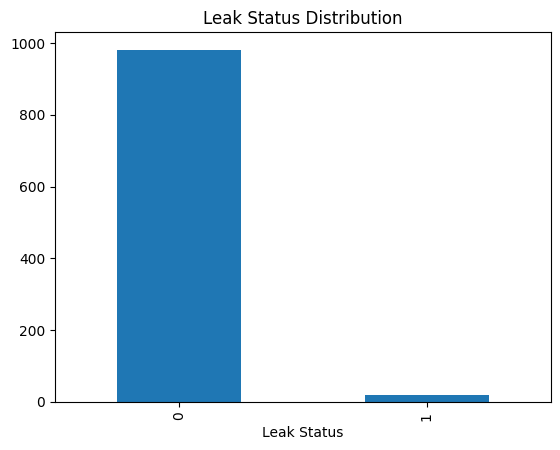

In [15]:
df['Leak Status'].value_counts().plot(kind='bar', title='Leak Status Distribution')

<b>1- Handling Imbalanced Data with <code>HistGradientBoostingClassifier</code><b>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.utils import compute_sample_weight


# Let's consider 'Leak Status' as target. Replace it if you want to model 'Burst Status'
TARGET = 'Leak Status'

# Features and target
feature_cols = [
    'Sensor_ID',
    'Pressure (bar)',
    'Flow Rate (L/s)',
    'Temperature (°C)',
]
X = df[feature_cols]
y = df[TARGET].astype(int)  

# Train/test split (stratify to preserve imbalance ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [18]:

# Compute sample weights inverse to class frequency
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Preprocessing: one-hot encode Sensor_ID, scale numericals
categorical_features = ['Sensor_ID']
numeric_features = ['Pressure (bar)', 'Flow Rate (L/s)', 'Temperature (°C)'] 

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features),
])

# Pipeline with estimator
clf = Pipeline([
    ('preproc', preprocessor),
    ('model', HistGradientBoostingClassifier(
        max_iter=200,
        early_stopping=True,
        random_state=42
    ))
])

# Fit with sample weights
clf.fit(X_train, y_train, model__sample_weight=sample_weights)




Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sensor_ID']),
                                                 ('num', StandardScaler(),
                                                  ['Pressure (bar)',
                                                   'Flow Rate (L/s)',
                                                   'Temperature (°C)'])])),
                ('model',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=200,
                                                random_state=42))])

In [19]:
# Predict and evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Classification report (test):")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

Classification report (test):
              precision    recall  f1-score   support

           0     0.9948    0.9847    0.9897       196
           1     0.5000    0.7500    0.6000         4

    accuracy                         0.9800       200
   macro avg     0.7474    0.8673    0.7949       200
weighted avg     0.9849    0.9800    0.9819       200

ROC AUC: 0.9783
PR AUC: 0.7926


<b>2- Synthetic Oversampling with <code>SMOTE</code><b>

SMOTE (Synthetic Minority Oversampling Technique) creates synthetic samples of the minority class in feature space. <br>
Pipeline:
<ol>
<li>Preprocess numeric and categorical features (SMOTE only works on numeric—so we need to encode categorical first).</li>

<li>Apply SMOTE to the training set to balance the class distribution.</li>

<li>Train a classifier (we’ll reuse HistGradientBoostingClassifier here, but you could swap in others).</li>

<li>Evaluate on untouched test set to see if oversampling improved recall/precision on minority class.</li>
</ol>

Dependencies: SMOTE is in imblearn. Install with <code>pip install imbalanced-learn</code> if not already present.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

df = pd.read_csv("./dataset/leak_detection_water_1000_rows.csv")


'''
Features used:
['Sensor_ID', 'Pressure (bar)', 'Flow Rate (L/s)', 'Temperature (°C)']

Target: e.g., 'Leak Status' converted to integer binary labels (0/1).
'''
TARGET = 'Leak Status'
feature_cols = [
    'Sensor_ID',
    'Pressure (bar)',
    'Flow Rate (L/s)',
    'Temperature (°C)',
    # 'hour', 'minute', 'second'
]
X = df[feature_cols]
y = df[TARGET].astype(int)

'''
Split data into training and test sets, preserving the class imbalance ratio in both via stratification on the target.

Result:

X_train, y_train (imbalanced)

X_test, y_test (held out, untouched distribution)
'''
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:

'''
Preprocessing transforms to apply to features:

Categorical: Sensor_ID → One-Hot Encoding (produces binary columns per sensor, handling unknowns gracefully).

Numerical: Pressure (bar), Flow Rate (L/s), Temperature (°C) → Standard Scaling (zero mean, unit variance).

This creates a numeric feature matrix from raw mixed-type input.
'''


# Preprocessing: encode categorical and scale numerics
categorical_features = ['Sensor_ID']
numeric_features = ['Pressure (bar)', 'Flow Rate (L/s)', 'Temperature (°C)'] 

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features),
])

''' 
Operation:

SMOTE synthesizes new minority-class examples by interpolating between existing minority samples in feature space.

The result is a balanced training set:

X_train_balanced (original + synthetic samples)

y_train_balanced (equalized class counts)
'''

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)), 
    ('model', HistGradientBoostingClassifier(
        max_iter=200,
        early_stopping=True,
        random_state=42
    ))
])

# Fit on training data (SMOTE will oversample minority class)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sensor_ID']),
                                                 ('num', StandardScaler(),
                                                  ['Pressure (bar)',
                                                   'Flow Rate (L/s)',
                                                   'Temperature (°C)'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=200,
                                                random_state=42))])

In [23]:

# Evaluate
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]


'''
Compare y_pred vs y_test and assess using metrics appropriate for imbalance:

Classification report (precision, recall, F1 per class)

ROC AUC

Precision-Recall curve and PR AUC

These reflect how well the model generalized without synthetic data leakage (since test set was untouched).
'''
print("Classification report (test):")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")


Classification report (test):
              precision    recall  f1-score   support

           0     0.9949    0.9949    0.9949       196
           1     0.7500    0.7500    0.7500         4

    accuracy                         0.9900       200
   macro avg     0.8724    0.8724    0.8724       200
weighted avg     0.9900    0.9900    0.9900       200

ROC AUC: 0.9796
PR AUC: 0.7242
